# Clustering and Manifold Learning

## Import Python Modules and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as mt 
import seaborn as sns

from matplotlib import cm
from sklearn.metrics import silhouette_samples
from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means and Birch clustering
from sklearn import preprocessing #needed for scaling attributes to the interval [0,1]

In [2]:
# overwrite Matplotlib's default parameters by seting the style 
# by calling Seaborn's set() method
sns.set()

### Load the dataset

Load the `loans_train_prepared.csv` dataset and read the dataset into an array as floats.

In [3]:
df = pd.read_csv("./loans_train_prepared.csv")
data = np.array(df.values, dtype=float)
print('(number of examples, number of attributes): ', data.shape)

(number of examples, number of attributes):  (614, 16)


## Quick Data Exploration

In [4]:
# Print the first 5 rows of the dataframe
df.head()

,Dependents,ApplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Gender_nan,Married_Yes,Married_nan,Self_Employed_Yes,Self_Employed_nan,Education_Not Graduate,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y,TotalIncome
0,0.000000,1.084523,1.058140,0.75,1,1,0,0,0,0,0,0,0,1,1,0.841086
1,0.333333,0.925883,1.047319,0.75,1,1,0,1,0,0,0,0,0,0,0,0.871711
2,0.000000,0.683858,0.635920,0.75,1,1,0,1,0,1,0,0,0,1,1,0.385189
3,0.000000,0.608992,1.002824,0.75,1,1,0,1,0,0,0,1,0,1,1,0.717012
4,0.000000,1.101869,1.115650,0.75,1,1,0,0,0,0,0,0,0,1,1,0.860305


In [5]:
# Print the last 5 rows of the dataframe
df.tail()

,Dependents,ApplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Gender_nan,Married_Yes,Married_nan,Self_Employed_Yes,Self_Employed_nan,Education_Not Graduate,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y,TotalIncome
609,0.000000,0.666409,0.676143,0.750,1,0,0,0,0,0,0,0,0,0,1,0.364708
610,1.000000,0.858916,0.395858,0.375,1,1,0,1,0,0,0,0,0,0,1,0.587496
611,0.333333,1.313719,1.566110,0.750,1,1,0,1,0,0,0,0,0,1,1,1.116075
612,0.666667,1.267616,1.325676,0.750,1,1,0,1,0,0,0,0,0,1,1,1.042256
613,0.000000,0.925883,1.074155,0.750,0,0,0,0,0,1,0,0,1,0,0,0.663523


Next, we examine some of the arrays to see how well prepared the data is. We select the first 10 arrays.

In [6]:
# examine a number of rows in the array to understand the data
data[1:10]

array([[0.33333333, 0.92588297, 1.04731899, 0.75      , 1.        ,
        1.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.87171097],
       [0.        , 0.68385824, 0.63592037, 0.75      , 1.        ,
        1.        , 0.        , 1.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 1.        , 1.        ,
        0.38518942],
       [0.        , 0.6089922 , 1.00282396, 0.75      , 1.        ,
        1.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 1.        , 1.        ,
        0.7170116 ],
       [0.        , 1.1018689 , 1.11564979, 0.75      , 1.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 1.        ,
        0.86030461],
       [0.66666667, 1.03316924, 1.61044516, 0.75      , 1.        ,
        1.        , 0.        , 

Next, we examine the attribute types.

In [7]:
df.dtypes

Dependents                 float64
ApplicantIncome            float64
LoanAmount                 float64
Loan_Amount_Term           float64
Credit_History               int64
Gender_Male                  int64
Gender_nan                   int64
Married_Yes                  int64
Married_nan                  int64
Self_Employed_Yes            int64
Self_Employed_nan            int64
Education_Not Graduate       int64
Property_Area_Semiurban      int64
Property_Area_Urban          int64
Loan_Status_Y                int64
TotalIncome                float64
dtype: object

## Scatterplot Function (to be used below for visualising a clustering)

In [8]:
colors = np.array(['orange', 'blue', 'green', 'grey', 'purple', 'lime', 'khaki', 'pink', 'yellow', 'red', 'brown', 'black'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot

def clustering_scatterplot(points, labels, centers, title):
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

The function `clustering_scatterplot()` creates the 2D scatter plot of the clustered dataset.

## K-Means Clustering

First, we set a value for `k` and then we run the `k-Means clustering` algorithm.

In [9]:
k = 2

We set the number of clusters `k`.

#### Run k-Means

In [10]:
clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300).fit(data)

### Apply a manifold-learning technique to project the data set to a 2D space

Here, we first add the cluster centers to the dataset and then we apply a manifold-learning technique called multi-dimensional scaling (MDS) to project the clusters into a 2D space.

In [11]:
data_and_centers = np.r_[data,clustered_data_sklearn.cluster_centers_]

We append the cluster centers to the dataset.

#### Apply multi-dimensional scaling (MDS) to project both the data and the k-Means cluster centers to a 2D space

In [12]:
XYcoordinates = manifold.MDS(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

transformation complete


We project both the data and the k-Means cluster centers to 2D.

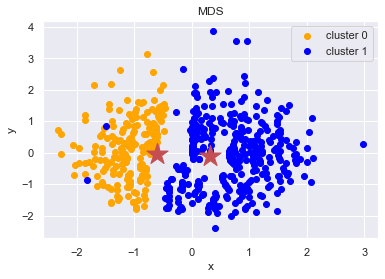

In [13]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS')

We plot the transformed examples and the centers, and we visually examine the results of the cluster.

#### Apply t-SNE to project both the data and the k-Means cluster centers to a 2D space

Next, we apply the t-SNE manifold technique to again project the data into 2D space.

In [14]:
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

transformation complete


We project both the data and the k-Means cluster centers to 2D.

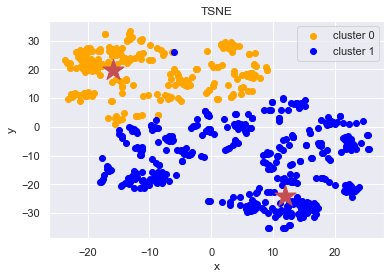

In [15]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_,
                       centers=XYcoordinates[-k:,:], 
                       title='TSNE')

We plot the transformed examples and the centers, and we visually examine the results of the cluster. The plot shows the clusters in a different way compared with the MDS method.

### Conclusion

Through visual inspection of several plots, it has been determined that when we set the value of `k` to `2` (`k = 2`), we get a clear gap between the two groups with some good clustering at the centroid and minimal overlap between clusters. When we set `k` to a higher value, there is a lot of crossing between clusters and some are very spread out.

## Cluster Analysis

#### Add the cluster labels as an extra column in the original dataframe

In [16]:
df['cluster'] = pd.Series(clustered_data_sklearn.labels_, index=df.index)

In [17]:
df.head()

,Dependents,ApplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Gender_nan,Married_Yes,Married_nan,Self_Employed_Yes,Self_Employed_nan,Education_Not Graduate,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y,TotalIncome,cluster
0,0.000000,1.084523,1.058140,0.75,1,1,0,0,0,0,0,0,0,1,1,0.841086,1
1,0.333333,0.925883,1.047319,0.75,1,1,0,1,0,0,0,0,0,0,0,0.871711,1
2,0.000000,0.683858,0.635920,0.75,1,1,0,1,0,1,0,0,0,1,1,0.385189,1
3,0.000000,0.608992,1.002824,0.75,1,1,0,1,0,0,0,1,0,1,1,0.717012,1
4,0.000000,1.101869,1.115650,0.75,1,1,0,0,0,0,0,0,0,1,1,0.860305,1


In [18]:
df.tail()

,Dependents,ApplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Gender_nan,Married_Yes,Married_nan,Self_Employed_Yes,Self_Employed_nan,Education_Not Graduate,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y,TotalIncome,cluster
609,0.000000,0.666409,0.676143,0.750,1,0,0,0,0,0,0,0,0,0,1,0.364708,1
610,1.000000,0.858916,0.395858,0.375,1,1,0,1,0,0,0,0,0,0,1,0.587496,1
611,0.333333,1.313719,1.566110,0.750,1,1,0,1,0,0,0,0,0,1,1,1.116075,1
612,0.666667,1.267616,1.325676,0.750,1,1,0,1,0,0,0,0,0,1,1,1.042256,1
613,0.000000,0.925883,1.074155,0.750,0,0,0,0,0,1,0,0,1,0,0,0.663523,0


#### Compute the mean value of each attribute for each cluster

In [19]:
df.groupby('cluster').mean()

,Dependents,ApplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Gender_nan,Married_Yes,Married_nan,Self_Employed_Yes,Self_Employed_nan,Education_Not Graduate,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y,TotalIncome
cluster,,,,,,,,,,,,,,,,
0,0.248927,0.914184,1.078738,0.723498,0.871245,0.738197,0.025751,0.648069,0.008584,0.137339,0.042918,0.197425,1.0,0.000000,0.768240,0.851417
1,0.247594,0.918059,1.074684,0.707152,0.845144,0.832021,0.018373,0.648294,0.002625,0.131234,0.057743,0.230971,0.0,0.530184,0.637795,0.869577


### Conclusion

From the table above, we can determine that `cluster 0` contains data rows with the data of a higher number of female customers living in semi-urban areas. `Cluster 1` contains data rows with the data of a higher number of male customers living in urban areas. 

Although through visual inspection we determined that for `k=2` we get a clear gap between the two groups with some good clustering at the centroid and minimal overlap between clusters, we can now see that values of `Dependents`, `ApplicantIncome`, `TotalIncome`, `LoanAmount` and `Credit_History` are pretty equally spread out between the two clusters. It may suggest that this clustering is not optimal as we cannot extract from it much useful information that would allow us to determine whether a loan can be granted or not. 

*Note that this conclusion is true for this run of k-Means. If the code is executed again, k-Means may produce either different clusters or the same clusters but in a different order.*

## The Elbow Method

#### Choosing the optimal number of clusters using the Elbow Method

We can use a graphical tool called the Elbow Method to estimate the optimal number of clusters `k` for a given task. The idea behind the Elbow Method is to identify the value of `k` where the distortion begins to increase most rapidly (Raschka and Mirjalili 2017).

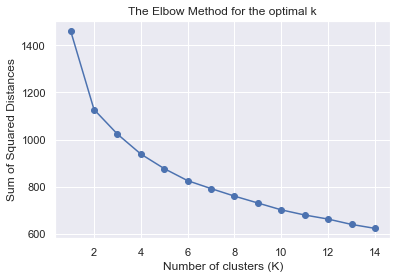

In [20]:
# adapted from
# https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion

# Plot the sum of squared distances 
data = df
# create an empty array
sum_of_squared_distances = {} 
for k in range(1, 15):
    kmeans = cluster.KMeans(n_clusters=k, max_iter=1000).fit(data)
    data["clusters"] = kmeans.labels_
    # Inertia: Sum of distances of samples to their closest cluster center
    sum_of_squared_distances[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sum_of_squared_distances.keys()), list(sum_of_squared_distances.values()), marker='o')
plt.xlabel("Number of clusters (K)")
plt.ylabel("Sum of Squared Distances")
plt.title("The Elbow Method for the optimal k")
plt.show()

As the value of `k` increases, the sum of squared distance tends to zero.

In the plot above, it is difficult to determine the elbow for this dataset. According to Larose (2015), the maximum number of components that should be extracted is just before where the plot first begins to straighten out into a horizontal line. However, here the curve in the plot is so gradual that no such elbow point is evident. When that is the case, we must turn to the other criteria, such as the Silhouette Method.

## The Silhouette Method

#### Choosing the optimal number of clusters using the Silhouette Method

The Silhouette Method is another metric that will allow us to evaluate the quality of a clustering. Silhouette analysis can be used as a graphical tool to plot a measure of how tightly grouped the samples in the clusters are. 

According to Raschka and Mirjalili (2017), to calculate the silhouette coefficient of a single sample in our dataset, we can apply the following three steps: 
- calculate the cluster cohesion as the average distance between a sample and all other points in the same cluster,
- calculate the cluster separation from the next closest cluster as the average distance between the sample and all samples in the nearest cluster,
- calculate the silhouette as the difference between cluster cohesion and separation divided by the greater of the two.

The silhouette coefficient is bounded in the range __-1__ to __1__. The silhouette coefficient is __0__ if the cluster separation and cohesion are equal. The ideal silhouette coefficient is equal to __1__ (Raschka and Mirjalili 2017).

#### Define a function to determine the optimal number of clusters using the Silhouette Method 

In [21]:
# adapted from
# Raschka and Mirjalili (2017)
def silhouette_coefficient(k):
    km = cluster.KMeans(n_clusters=k, random_state=0)
    y_km = km.fit_predict(data)
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(data, y_km, metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color='red', linestyle='--') 
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.show()

#### The Silhouette Method for k = 2

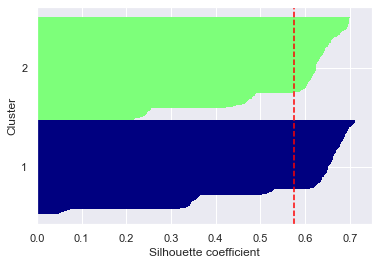

In [22]:
silhouette_coefficient(2)

Through visual inspection of the silhouette plot, we can examine the sizes of the different clusters and identify clusters that contain outliers. The dotted red line on the plot indicates the average silhouette coefficient and allows us to summarize the goodness of our clustering.

However, as we can see in the preceding silhouette plot, the silhouette coefficients are not even close to 0, which is, in this case, an indicator of a good clustering (Raschka and Mirjalili 2017).

#### The Silhouette Method for k = 3

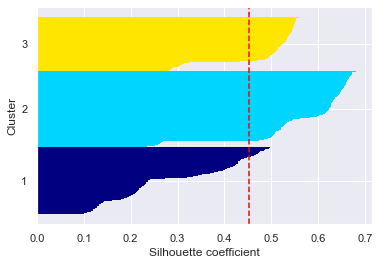

In [23]:
silhouette_coefficient(3)

As we can see in the resulting plot, the silhouettes have visibly different lengths and widths. According to Raschka and Mirjalili (2017), this is evidence for a relatively bad or at least suboptimal clustering.

#### The Silhouette Method for k = 4

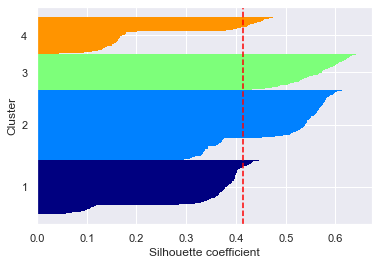

In [24]:
silhouette_coefficient(4)

The silhouettes again have visibly different lengths and widths. As Raschka and Mirjalili (2017) explain, this is evidence for a relatively bad or at least suboptimal clustering.

#### The Silhouette Method for k = 8

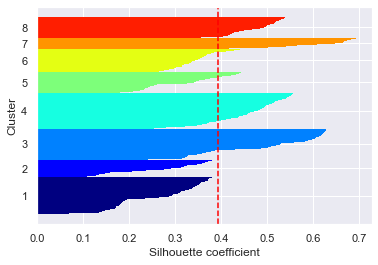

In [25]:
silhouette_coefficient(8)

The silhouettes again have visibly different lengths and widths. This again is evidence of a relatively bad or at least suboptimal clustering (Raschka and Mirjalili 2017).

#### The Silhouette Method for k = 10

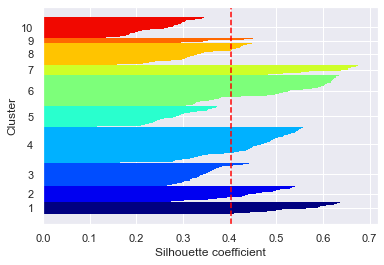

In [26]:
silhouette_coefficient(10)

The silhouettes again have visibly different lengths and widths. This again is evidence of a relatively bad or at least suboptimal clustering (Raschka and Mirjalili 2017).

## Birch Clustering Algorithm

`BIRCH` stands for `Balanced Iterative Reducing and Clustering using Hierarchies` (Larose 2015). The Birch clustering algorithm is a memory-efficient alternative of the k-Means clustering that has the ability to find a good clustering solution with only a single scan of the data. Therefore, this clustering technique is particularly useful for very large data sets or data streaming (Larose 2015).

The Birch clustering algorithm is sometimes referred to as Two-Step Clustering because it consists of two distinct phases:
- loading the data into memory by building a cluster-feature tree,
- apply an existing clustering algorithm on the leaves of the cluster-feature tree (Larose 2015).

#### Convert the dataframe to a numpy array

In [27]:
# convert the dataframe to a numpy array
data_arr = df.to_numpy()

#### Rescale the values in each column to the interval [0,1] with MinMaxScaler

In [28]:
min_max_scaler = preprocessing.MinMaxScaler()
data_arr = min_max_scaler.fit_transform(data_arr)

__Note__

Although rescaling again the data in the `loans_train_prepared.csv` is __not necessary__ because the data in this dataset was rescaled as part of `E-tivity 2`, doing so here allows us to obtain better results of `Birch clustering` and generate more useful plots of the clusters.

#### Define a function to apply Birch clustering and plot results

In [29]:
def birch_clustering(k):
    
    # perform Birch clustering
    brc = cluster.Birch(branching_factor=50, n_clusters=k, threshold=0.5)
    brc.fit(data_arr)
    labels = brc.predict(data_arr)
    
    # calculate the Silhouette Score of the clustering
    print('The Silhouette Score of the clustering: ', mt.silhouette_score(data_arr, np.array(labels), metric='euclidean'))
    
    # apply a manifold-learning technique to project the data set to a 2D space
    data_transformed = manifold.MDS(n_components=2).fit_transform(data_arr)
    
    # plot Birch clustering
    plt.scatter(data_transformed[:,0], data_transformed[:,1], c=labels, cmap='rainbow', alpha=0.7, edgecolors='b')
    plt.show()
    
    return labels

The results of Birch clustering will be evaluated using the `Silhouette Score`, in addition to `visual inspection of the plots`. This metric computes the `mean Silhouette Coefficient` of all samples, which is calculated using the mean intra-cluster distance and the mean nearest-cluster distance for each sample (Scikit Learn silhouette_score n.d.)

The best value is __1__, the worst is __-1__, and values near __0__ indicate overlapping clusters (Scikit Learn silhouette_score n.d.). Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar (Scikit Learn silhouette_score n.d.).

#### Birch clustering without the value of k set

If the `number of clusters` (`k`) in the Birch clustering has not been set (`None`), the final clustering step is not performed and the subclusters are returned as they are (Scikit Learn Birch n.d.).

The Silhouette Score of the clustering:  0.4285176746932347


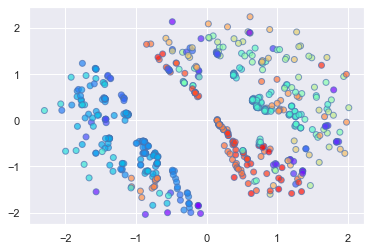

array([ 68, 173,  98,  69,  68, 138,  69,  33,  70,  34, 139,  90,  70,
        15, 139,  68,  96,   1,  10,  71,  12,  70,   2,   3,  16,  35,
        36,  69, 101,  37,  72, 126, 102,  36,  18,  70,  14,  43,  68,
        19, 126,  68,  70,  36,  73,  20,  70,  70,   4,  38,  39,  38,
        54,  74, 104,  36,  36,  76,  70,  69,  70, 139, 105, 131,  40,
        34, 106,  70, 140,  40,  70, 141,  41,   5, 142, 126,  80, 143,
        33, 141,  38,  46, 107,  34,  70,  41, 144,  36,  68,  42,  36,
        42,  69,  41,  19,  17,  43,  36,  49,  36,  69,  41,  70,  36,
        75,  70,  70,  21, 103, 144,  68,  44,   6,  45,  41, 145,  43,
        70,  76,  94, 145,  38,  40,  36,  77,  22, 146, 157, 109,  76,
        79,  68,  41,  46,  41,  34,   7, 138,  23,  99, 147,  68,  47,
        36,  70,  43, 148,  70,  24,  36,  25, 149,  80,  99,  68,  48,
       145,  70,  81,  42,  49,  82,  33, 162,  70, 145,  83, 145,  23,
        42,  84, 150, 166,  42,  50, 145, 162,  33,  36, 106, 11

In [30]:
birch_clustering(None)

#### Birch clustering for k = 2

The Silhouette Score of the clustering:  0.2633953052264524


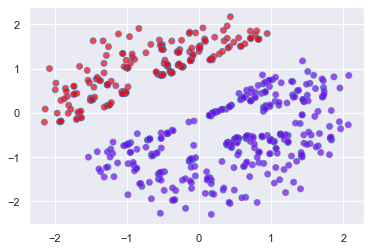

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,

In [31]:
birch_clustering(2)

#### Birch clustering for k = 3

The Silhouette Score of the clustering:  0.2203237682857352


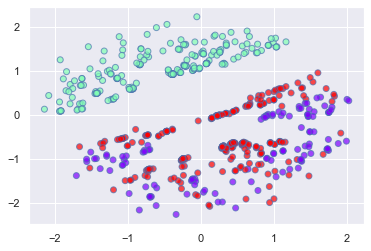

array([2, 0, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 0, 2,
       1, 0, 1, 1, 1, 2, 0, 1, 0, 0, 2, 1, 0, 2, 0, 1, 2, 1, 0, 2, 2, 1,
       2, 2, 2, 2, 0, 1, 1, 1, 1, 0, 2, 1, 1, 0, 2, 2, 2, 2, 0, 0, 1, 1,
       0, 2, 2, 1, 2, 1, 1, 1, 1, 0, 0, 2, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1,
       2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 0, 0, 1,
       2, 1, 0, 1, 1, 2, 1, 2, 0, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 0, 2, 2,
       1, 1, 1, 1, 0, 2, 1, 0, 0, 2, 1, 1, 2, 1, 2, 2, 0, 1, 0, 2, 0, 0,
       2, 1, 2, 2, 2, 1, 1, 0, 1, 2, 2, 2, 0, 2, 1, 1, 2, 2, 0, 1, 1, 2,
       2, 1, 1, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 0, 1, 2, 1, 2, 2,
       1, 2, 1, 1, 0, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 0, 2, 2, 1, 2, 0,
       2, 2, 1, 2, 2, 2, 1, 2, 1, 0, 2, 1, 2, 2, 0, 0, 0, 1, 2, 1, 1, 2,
       1, 2, 1, 2, 0, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 0, 1, 2, 2, 0, 2,
       1, 2, 1, 2, 2, 1, 2, 0, 1, 2, 1, 2, 0, 0, 0,

In [32]:
birch_clustering(3)

#### Birch clustering for k = 5

The Silhouette Score of the clustering:  0.2105476224547412


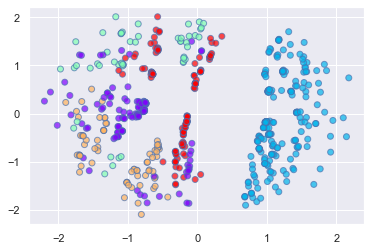

array([4, 3, 0, 0, 4, 0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 4, 4, 2, 3, 0, 3, 0,
       1, 3, 1, 1, 1, 0, 2, 1, 3, 2, 0, 1, 2, 0, 3, 1, 4, 1, 2, 4, 0, 1,
       0, 4, 0, 0, 3, 1, 1, 1, 1, 3, 0, 1, 1, 3, 0, 0, 0, 0, 3, 3, 1, 1,
       2, 0, 0, 1, 0, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 3, 1, 0, 1, 1, 1,
       4, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 0, 1, 0, 1, 4, 0, 0, 2, 3, 1,
       4, 1, 3, 1, 1, 4, 1, 0, 3, 4, 4, 1, 1, 1, 4, 4, 0, 4, 0, 3, 0, 4,
       1, 1, 1, 1, 3, 0, 1, 3, 3, 4, 1, 1, 0, 1, 0, 0, 2, 1, 2, 0, 2, 3,
       4, 1, 4, 0, 4, 1, 1, 3, 1, 4, 0, 4, 3, 4, 1, 1, 4, 0, 3, 1, 1, 4,
       4, 1, 1, 2, 2, 2, 1, 1, 1, 1, 0, 4, 0, 4, 4, 1, 3, 1, 4, 1, 4, 4,
       1, 0, 1, 1, 3, 0, 1, 1, 4, 4, 4, 1, 1, 1, 0, 0, 0, 1, 3, 1, 1, 1,
       3, 1, 1, 1, 1, 3, 0, 1, 1, 0, 1, 4, 4, 1, 1, 4, 3, 4, 4, 1, 4, 3,
       4, 0, 1, 0, 0, 0, 1, 0, 1, 2, 4, 1, 0, 4, 2, 3, 3, 1, 0, 1, 1, 4,
       1, 4, 1, 0, 2, 4, 4, 0, 4, 1, 1, 1, 1, 0, 1, 4, 2, 1, 0, 4, 3, 4,
       1, 4, 1, 4, 4, 1, 0, 2, 1, 0, 1, 0, 2, 3, 3,

In [33]:
birch_clustering(5)

#### Birch clustering for k = 8

The Silhouette Score of the clustering:  0.19343097563499334


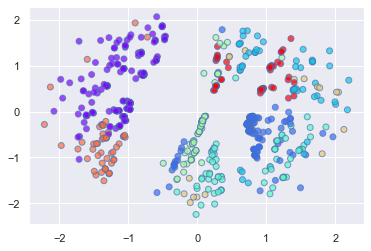

array([7, 3, 1, 1, 7, 1, 1, 6, 1, 6, 1, 1, 1, 2, 1, 7, 7, 2, 3, 1, 3, 1,
       6, 3, 6, 0, 0, 1, 2, 0, 3, 2, 5, 0, 2, 1, 3, 0, 7, 0, 2, 7, 1, 0,
       1, 7, 1, 1, 3, 0, 0, 0, 0, 3, 5, 0, 0, 3, 1, 1, 1, 1, 3, 3, 0, 6,
       2, 1, 1, 0, 1, 6, 0, 6, 0, 2, 2, 1, 6, 6, 0, 0, 3, 6, 1, 0, 6, 0,
       7, 0, 0, 0, 1, 0, 0, 2, 0, 0, 6, 0, 1, 0, 1, 0, 7, 1, 1, 2, 3, 6,
       7, 0, 3, 0, 0, 4, 0, 1, 3, 7, 4, 0, 0, 0, 4, 7, 1, 7, 5, 3, 5, 7,
       0, 0, 0, 6, 3, 1, 0, 3, 3, 7, 0, 0, 1, 0, 1, 1, 2, 0, 2, 1, 2, 3,
       7, 0, 4, 1, 7, 0, 6, 3, 6, 4, 1, 4, 3, 4, 0, 0, 4, 1, 3, 0, 6, 4,
       4, 6, 0, 2, 2, 2, 0, 6, 0, 0, 5, 4, 1, 4, 4, 0, 3, 0, 7, 6, 7, 4,
       0, 5, 6, 0, 3, 1, 6, 0, 7, 4, 7, 0, 0, 6, 1, 1, 1, 6, 3, 0, 6, 0,
       3, 0, 0, 0, 0, 3, 1, 0, 0, 5, 0, 4, 4, 0, 0, 4, 3, 7, 7, 0, 4, 3,
       7, 1, 6, 5, 1, 1, 0, 1, 6, 2, 4, 6, 5, 7, 2, 3, 3, 6, 1, 0, 0, 7,
       0, 7, 0, 1, 2, 7, 7, 1, 7, 0, 0, 0, 0, 1, 0, 4, 2, 0, 1, 7, 3, 7,
       0, 4, 0, 7, 4, 6, 1, 2, 0, 1, 0, 1, 2, 3, 3,

In [34]:
birch_clustering(8)

### Conclusion

The first Birch clustering, in which the `numbers of clusters` (`k`) has not been set (`None`) achieved the highest `Silhouette Score` of `0.43`. However, through visual inspection of the plot, we can determine that this clustering does not give us a clear gap between the clusters. There is a lot of crossing between the clusters, and some are very spread out.

None of the other examined Birch clusterings of the `loans_train_prepared.csv` dataset has particularly high mean Silhouette Coefficient of all samples (the closer to 1, the better). However, the first Birch clustering (`k = 2`) achieved the highest `Silhouette Score` of `0.26` among all the examined Birch clusterings with the value of `k` set. 

Furthermore, through visual inspection of the plots, we can determine that when we set the value of `k` to `2` (`k = 2`), we get a clear gap between the two groups and minimal overlap between clusters. When we set `k` to a higher value, there is a lot of crossing between clusters and some are very spread out.

## The Analysis of Birch Clustering

The Silhouette Score of the clustering:  0.2633953052264524


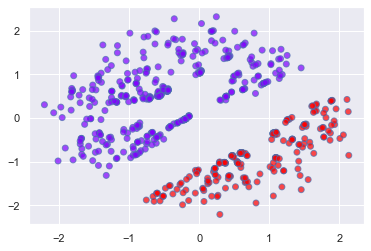

In [35]:
labels = birch_clustering(2)

#### Add the cluster labels as an extra column in the original dataframe

In [36]:
df['cluster'] = pd.Series(labels, index=df.index)

#### Compute the mean value of each attribute for each cluster

In [37]:
df.groupby('cluster').mean()

,Dependents,ApplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Gender_nan,Married_Yes,Married_nan,Self_Employed_Yes,Self_Employed_nan,Education_Not Graduate,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y,TotalIncome,clusters
cluster,,,,,,,,,,,,,,,,,
0,0.247594,0.918059,1.074684,0.707152,0.845144,0.832021,0.018373,0.648294,0.002625,0.131234,0.057743,0.230971,0.0,0.530184,0.637795,0.869577,6.091864
1,0.248927,0.914184,1.078738,0.723498,0.871245,0.738197,0.025751,0.648069,0.008584,0.137339,0.042918,0.197425,1.0,0.000000,0.768240,0.851417,6.914163


### Conclusion

From the table above, we can determine that the results of the `Birch clustering` algorithm for `k=2` are very similar to the clustering results obtained from the `k-Means clustering` algorithm.

Although through visual inspection we determined that for `k=2` we get a clear gap between the two clusters and no overlap (or minimal overlap) between clusters, we can now see that values of `Dependents`, `ApplicantIncome`, `TotalIncome`, `LoanAmount` and `Credit_History` are pretty equally spread out between the two clusters. It may suggest that this clustering is not optimal as we cannot extract from it much useful information that would allow us to determine whether a loan can be granted or not.

*Note that this conclusion is true for this run of the Birch clustering algorithm. If the code is executed again, the Birch algorithm may produce either different clusters or the same clusters but in a different order.*

## References

Larose, D.T. (2015) *Data Mining and Predictive Analytics*, 2nd ed., Hoboken: John Wiley & Sons.

Maklin, C. (2019) *BIRCH Clustering Algorithm Example In Python*, Towards Data Science, available: https://towardsdatascience.com/machine-learning-birch-clustering-algorithm-clearly-explained-fb9838cbeed9 [accessed 05 Apr 2020].

Raschka, S. and Mirjalili, V. (2017) *Python Machine Learning*, 2nd ed., Birmingham: Packt Publishing.

Scikit Learn Birch (n.d.) *sklearn.cluster.Birch*, Scikit Learn, available: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.Birch.html [accessed 04 Apr 2020].

Scikit Learn silhouette_score (n.d.) *sklearn.metrics.silhouette_score*, Scikit Learn, available: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html [accessed 05 Apr 2020].

StackOverflow (2013) *Scikit Learn - K-Means - Elbow - criterion*, available: https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion [accessed 04 Apr 2020].